# Import Libraries

In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [2]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [4]:
categories = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8}

train["category"] = train["category"].map(categories)
test["category"] = test["category"].map(categories)

In [5]:
# exclude 'F' from each column
train=train[train.views!='F']
train=train[train.likes!='F']
train=train[train.dislikes!='F']
train=train[train.comment!='F']
train['views'] = pd.to_numeric(train['views'])
train['likes'] = pd.to_numeric(train['likes'])
train['dislikes'] = pd.to_numeric(train['dislikes'])
train['comment'] = pd.to_numeric(train['comment'])
train['adview'] = pd.to_numeric(train['adview'])

test = test[test.views!='F']
test = test[test.likes!='F']
test = test[test.dislikes!='F']
test = test[test.comment!='F']
test['views'] = pd.to_numeric(test['views'])
test['likes'] = pd.to_numeric(test['likes'])
test['dislikes'] = pd.to_numeric(test['dislikes'])
test['comment'] = pd.to_numeric(test['comment'])

## Preprocessing

In [6]:
from sklearn.preprocessing import LabelEncoder
train['duration'] = LabelEncoder().fit_transform(train['duration'])
train['vidid'] = LabelEncoder().fit_transform(train['vidid'])
train['published'] = LabelEncoder().fit_transform(train['published'])

test['duration'] = LabelEncoder().fit_transform(test['duration'])
test['vidid'] = LabelEncoder().fit_transform(test['vidid'])
test['published'] = LabelEncoder().fit_transform(test['published'])

In [7]:
def checki(x):
    y = x[2:]
    h, m, s, mm = "", "", "", ""
    P = ["H", "M", "S"]
    for i in y:
        if i not in P:
            mm += i
        else:
            if i == P[0]:
                h = mm
                mm = ""
            elif i == P[1]:
                m = mm
                mm = ""
            else:
                s = mm
                mm = ""
    if h == "":
        h = "00"
    if m == "":
        m = "00"
    if s == "":
        s = "00"
    bp = h + ":" + m + ":" + s
    return bp

In [8]:
def func_sec(time_str):
    h, m, s = time_str.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

In [9]:
mp_train = pd.read_csv('train.csv')['duration']
mp_test = pd.read_csv('test.csv')['duration']
time_train = mp_train.apply(checki)
time_test = mp_test.apply(checki)

time_1 = time_train.apply(func_sec)
time_2 = time_test.apply(func_sec)

train['duration'] = time_1
test['duration'] = time_2

In [10]:
# corr
train.corr()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
vidid,1.000000,-0.014456,-0.047528,-0.128769,-0.076344,-0.081038,-0.144433,0.006903,-0.038885
adview,-0.014456,1.000000,0.032807,0.044650,0.036609,0.016104,0.039276,-0.012710,0.008065
views,-0.047528,0.032807,1.000000,0.726716,0.730320,0.410662,0.020330,0.002509,0.033055
likes,-0.128769,0.044650,0.726716,1.000000,0.648876,0.651202,0.097183,-0.042572,-0.008875
dislikes,-0.076344,0.036609,0.730320,0.648876,1.000000,0.532548,0.044100,0.001495,0.011759
comment,-0.081038,0.016104,0.410662,0.651202,0.532548,1.000000,0.114334,-0.037499,-0.034003
published,-0.144433,0.039276,0.020330,0.097183,0.044100,0.114334,1.000000,0.011942,-0.056659
duration,0.006903,-0.012710,0.002509,-0.042572,0.001495,-0.037499,0.011942,1.000000,0.049195
category,-0.038885,0.008065,0.033055,-0.008875,0.011759,-0.034003,-0.056659,0.049195,1.000000


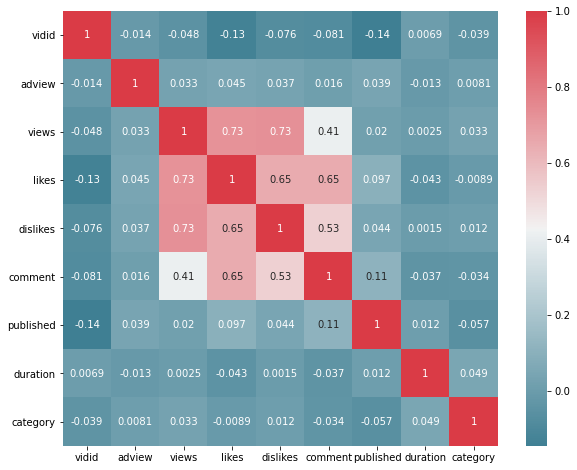

In [11]:
f, ax = plt.subplots(figsize=(10, 8))
corr= train.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square = True, ax= ax, annot=True)
plt.show()

In [12]:
# split data
X = train.iloc[:, 2:9]
y = train.iloc[:, 1]

In [13]:
test = test.drop(['vidid'], axis=1)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                   random_state=42)
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()

In [15]:
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

In [16]:
def evaluate(model, X_val, y_val):
    preds = model.predict(X_val)
    print("Mean Squared Error: ", mean_squared_error(y_val, preds))
    print("RMSE: ", np.sqrt(mean_squared_error(y_val, preds)))

## Linear Regression

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)
evaluate(model, X_val, y_val)

Mean Squared Error:  10869761930.328465
RMSE:  104258.15042637417


## Logistic Regression

In [18]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
evaluate(log_reg, X_val, y_val)

Mean Squared Error:  10901313277.888319
RMSE:  104409.35436007791


C:\Users\markn\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## SVC

In [18]:
svr_reg = SVR()
svr_reg.fit(X_train, y_train)
evaluate(svr_reg, X_val, y_val)

Mean Squared Error:  10901289279.001965
RMSE:  104409.23943311705


## Decision Tree

In [19]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
evaluate(tree_reg, X_val, y_val)

Mean Squared Error:  12373804080.82616
RMSE:  111237.60191961243


## Random forest

In [20]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
evaluate(forest, X_val, y_val)

Mean Squared Error:  10000899303.192146
RMSE:  100004.496414872


## Neural Network

In [22]:
model = keras.models.Sequential([
                keras.layers.Dense(16, input_shape=(7,), activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(8, activation='relu'),
                keras.layers.Dense(units=1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit(X_train, y_train, epochs=300, verbose=0)

In [23]:
evaluate(model, X_val, y_val)

Mean Squared Error:  10839951584.974098
RMSE:  104115.08817157145


## Save the model

In [21]:
joblib.dump(forest, "ml_model.pkl")

['ml_model.pkl']

## Load the model

In [22]:
model = joblib.load('ml_model.pkl')
preds = model.predict(test)
preds

array([   9.59, 1213.12,    1.37, ...,   10.92,  258.2 , 1138.9 ])

In [23]:
preds = preds.astype(np.int16)

## Store data in Dataframe

In [24]:
preds = preds.reshape(1, -1)[0].tolist()
result = {'adview': preds}
pd.DataFrame(result).to_csv('predictions.csv', index=False)

In [25]:
pd.read_csv('predictions.csv')

,adview
0,9
1,1213
2,1
3,62
4,8
...,...
8544,8
8545,7
8546,10
8547,258
